In [1]:
import csv
import re
import pathlib
import torch

epoch_pattern = re.compile(r"^starting epoch:\s*(\d+)")
starting_pattern = re.compile(r"^Starting training.*")
train_metrics_pattern = re.compile(r"Train -\s+loss:\s*([\d.]+)\s+top-1:\s*([\d.]+)\s+top-5:\s*([\d.]+)\s+top-10:\s*([\d.]+)")
eval_metrics_pattern = re.compile(r"Eval -\s+loss:\s*([\d.]+)\s+top-1:\s*([\d.]+)\s+top-5:\s*([\d.]+)\s+top-10:\s*([\d.]+)")

name_var_pattern = re.compile(r"-?((?P<varname>[a-zA-Z\-_]+)=(?P<value>\-?\d+\.?\d*(e\-?\d+)?))")
name_pattern = re.compile(r"^(?P<exp_group>[\d]+)?\-?(?P<Layer>.+)(?P<Position>Pre|Post|Both)(?P<DyTfn>.*tanh)?(?P<Vars>(([a-zA-Z\-_]+)=([\d\.e\-]+))*)$")

def read_grad_l2(pth_file):
    grads = torch.load(pth_file)

    sections = {".".join(key.split('.')[4:]) for key in grads.keys() if len(key.split('.')) >= 4}

    grads_l2 = {key: [] for key in sections}
    for i, key in enumerate(grads.keys()):
        section = key.split(".")
        if len(section) < 3:
            continue
        section = ".".join(section[4:])
        grads_l2[section].append(torch.norm(grads[key], p=2).item())
        
    return grads_l2


def parse_name(name):
    out = {"exp_group":1, 'lr':1e-4, 'dim_hidden':256}
    search = name_pattern.search(name)
    if search is None:
        out["Layer"] = "Identity"
        out["Position"] = "Both"
        return out
    out["Layer"] = search.group("Layer")
    if out["Layer"]=="DyT":
        out["Alpha"] = 0.5
        out["DyTfn"] = "Tanh"
    out["Position"] = search.group("Position")
    if search.group("DyTfn") is not None:
        out["DyTfn"] = search.group("DyTfn")
    if search.group("exp_group") is not None:
        out["exp_group"] = int(search.group("exp_group"))
    out.update({e[1]:float(e[2]) for e in name_var_pattern.findall(search.group("Vars"))})
    return out

def read_log(folder):
    data_rows = []
    current_epoch = None
    train_metrics = {}
    eval_metrics = {}
    english = None
    french = None
    current_model = folder.name
    smallest_epoch = None
    
    with open(folder/"training_logs.log", "r", encoding="utf-8") as f:
        current_model_data = []
        for line in f.readlines():
            line = line.strip()
            
            if match := starting_pattern.match(line):
                continue

            if match := epoch_pattern.match(line):
                if smallest_epoch is None:
                    smallest_epoch = int(match.group(1))
                current_epoch = int(match.group(1))-smallest_epoch
                continue

            if match := train_metrics_pattern.match(line):
                train_metrics = {
                    "Train Loss": float(match.group(1)),
                    "Train Top-1": float(match.group(2)),
                    "Train Top-5": float(match.group(3)),
                    "Train Top-10": float(match.group(4)),
                }
                continue

            if match := eval_metrics_pattern.match(line):
                eval_metrics = {
                    "Eval Loss": float(match.group(1)),
                    "Eval Top-1": float(match.group(2)),
                    "Eval Top-5": float(match.group(3)),
                    "Eval Top-10": float(match.group(4)),
                }
                continue

            if english is None:
                english = line
                continue
            elif french is None:
                french = line
                row = {
                    **parse_name(current_model),
                    "Exp_full_name": current_model,
                    "Epoch": current_epoch,
                    "Ground Truth": english,
                    "Prediction": french,
                    **train_metrics,
                    **eval_metrics,
                    "grads":read_grad_l2(folder/f"grads_epoch_start_epoch_{current_epoch}.pth")
                }
                current_model_data.append(row)
                english = None
                french = None
                continue
            
    data_rows.extend(current_model_data)
    current_model_data = []
    return data_rows


In [2]:

import matplotlib.pyplot as plt
import math
import copy
import numpy as np

def make_fig_axes(name="", ncols=4, nrows = 7, figsize=(20, 16)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(name)
    return fig, axes

def plot_multiple_grads(df, name="", name_fn=lambda row: row[0], ncols=4, figsize=(20, 16)):
    keys = {"Average L2 gradient per layer"}
    for grad in df["grads"]:
        keys.update(grad.keys())
    keys = sorted(keys)
    fig, axes =  make_fig_axes(name=name, ncols=ncols, nrows=int(math.ceil((len(keys))/ncols)), figsize=figsize)

    legend_names = []
    for row in df.iterrows():
        legend_names.append(name_fn(row))

    grads = []
    legends = [[] for _ in keys]
    for i, grad in enumerate(df["grads"]): 
        grad = copy.deepcopy(grad)
        legend = []

        grad["Average L2 gradient per layer"] = list(np.array([v for v in grad.values()]).mean(axis=0))
        for j,key in enumerate(keys):
            value = grad.get(key, None)
            if value is not None:
                if len(value)!=0:
                    legends[j].append(legend_names[i])
                else:
                    value=None
            grad[key] = value
        
        grads.append(grad)

    for grad in grads:
        fig, axes = plot_grads(grad, fig, axes)

    for i, legend in enumerate(legends):
        ax = axes[i // ncols, i % ncols]
        ax.legend(legend)

    plt.tight_layout()
    return fig, axes


def plot_grads(grads, fig=None, axes=None):
    if fig is None or axes is None:
        fig, axes = make_fig_axes()
    nrows, ncols = axes.shape
    for i, key in enumerate(sorted(grads.keys())):
        if grads[key] is None:
            continue
        ax = axes[i // ncols, i % ncols]
        ax.plot(grads[key])
        ax.set_xlabel('Transformer Block')
        ax.set_ylabel('Gradient L2')
        ax.set_title(key)

    plt.tight_layout()
    return fig, axes

In [3]:
gt = {'BatchNormBoth',
 'BatchNormPost',
 'BatchNormPre',
 'DyTBoth',
 'DyTBothAlpha=0.05',
 'DyTBothHardtanh',
 'DyTBothHardtanhAlpha=0.05',
 'DyTBothLeakyHardtanh',
 'DyTBothLeakyHardtanhAlpha=0.05',
 'DyTPost',
 'DyTPostAlpha=0.05',
 'DyTPostHardtanh',
 'DyTPostHardtanhAlpha=0.05',
 'DyTPostLeakyHardtanh',
 'DyTPostLeakyHardtanhAlpha=0.05',
 'DyTPre',
 'DyTPreAlpha=0.05',
 'DyTPreHardtanh',
 'DyTPreHardtanhAlpha=0.05',
 'DyTPreLeakyHardtanh',
 'DyTPreLeakyHardtanhAlpha=0.05',
 'Identity',
 'LayernormBoth',
 'LayernormPost',
 'LayernormPre',
 'RMSNormBoth',
 'RMSNormPost',
 'RMSNormPre',
 '2-DyTPost-lr=0.0002',
 '2-DyTPost-lr=0.0004',
 '2-DyTPost-lr=2.5e-05',
 '2-DyTPost-lr=5e-05',
 '2-LayernormPost-lr=0.0002',
 '2-LayernormPost-lr=0.0004',
 '2-LayernormPost-lr=2.5e-05',
 '2-LayernormPost-lr=5e-05',
 '2-DyTPostHardtanhAlpha=0.5-dim_hidden=512',
 '2-DyTPostAlpha=0.5-dim_hidden=512',
 '2-DyTPreAlpha=1.0',
 '2-DyTPreHardtanhAlpha=1.0',
 '2-DyTPreLeakyHardtanhAlpha=1.0',
 '3-DyTPostAlpha=1.0',
 '3-DyTPostHardtanhAlpha=1.0',
 '3-DyTPostLeakyHardtanhAlpha=1.0',
 '3-DyTPre-lr=0.0002',
 '3-DyTPre-lr=0.0004',
 '3-DyTPre-lr=2.5e-05',
 '3-DyTPre-lr=5e-05',
 '3-DyTPre-dim_hidden=512',
 '3-DyTPreHardtanh-dim_hidden=512',
 '3-DyTPreLeakyHardtanh-dim_hidden=512',
 '3-LayernormPre-lr=0.0002',
 '3-LayernormPre-lr=0.0004',
 '3-LayernormPre-lr=2.5e-05',
 '3-LayernormPre-lr=5e-05',
 '2-DyTPostLeakyHardtanhAlpha=0.5-dim_hidden=512'}
seen = set([e.name for e in pathlib.Path("logs").glob("*") if e.is_dir()])

assert len(seen.difference(gt))==0 and len(gt.difference(seen))==0, f"Extra folders found:{seen.difference(gt)}, Missing folders: {gt.difference(seen)}"

In [4]:
runs = [e for e in pathlib.Path("logs").glob("*") if e.is_dir()]

In [5]:
logs = []
for e in runs: 
    logs += read_log(e)

In [6]:
data = {k:[] for e in logs for k in e.keys()}

for e in logs:
    for k in data.keys():
        data[k].append(e.get(k))


In [7]:
import pandas as pd

In [8]:
cols = ["Layer","Position","Epoch","Train Loss","Eval Loss","Alpha","DyTfn","exp_group","lr","dim_hidden","Exp_full_name","Ground Truth","Prediction","Train Top-1","Train Top-5","Train Top-10","Eval Top-1","Eval Top-5","Eval Top-10", "grads"]

df = pd.DataFrame(data, columns=cols)
df.to_csv("out.csv", index=False)


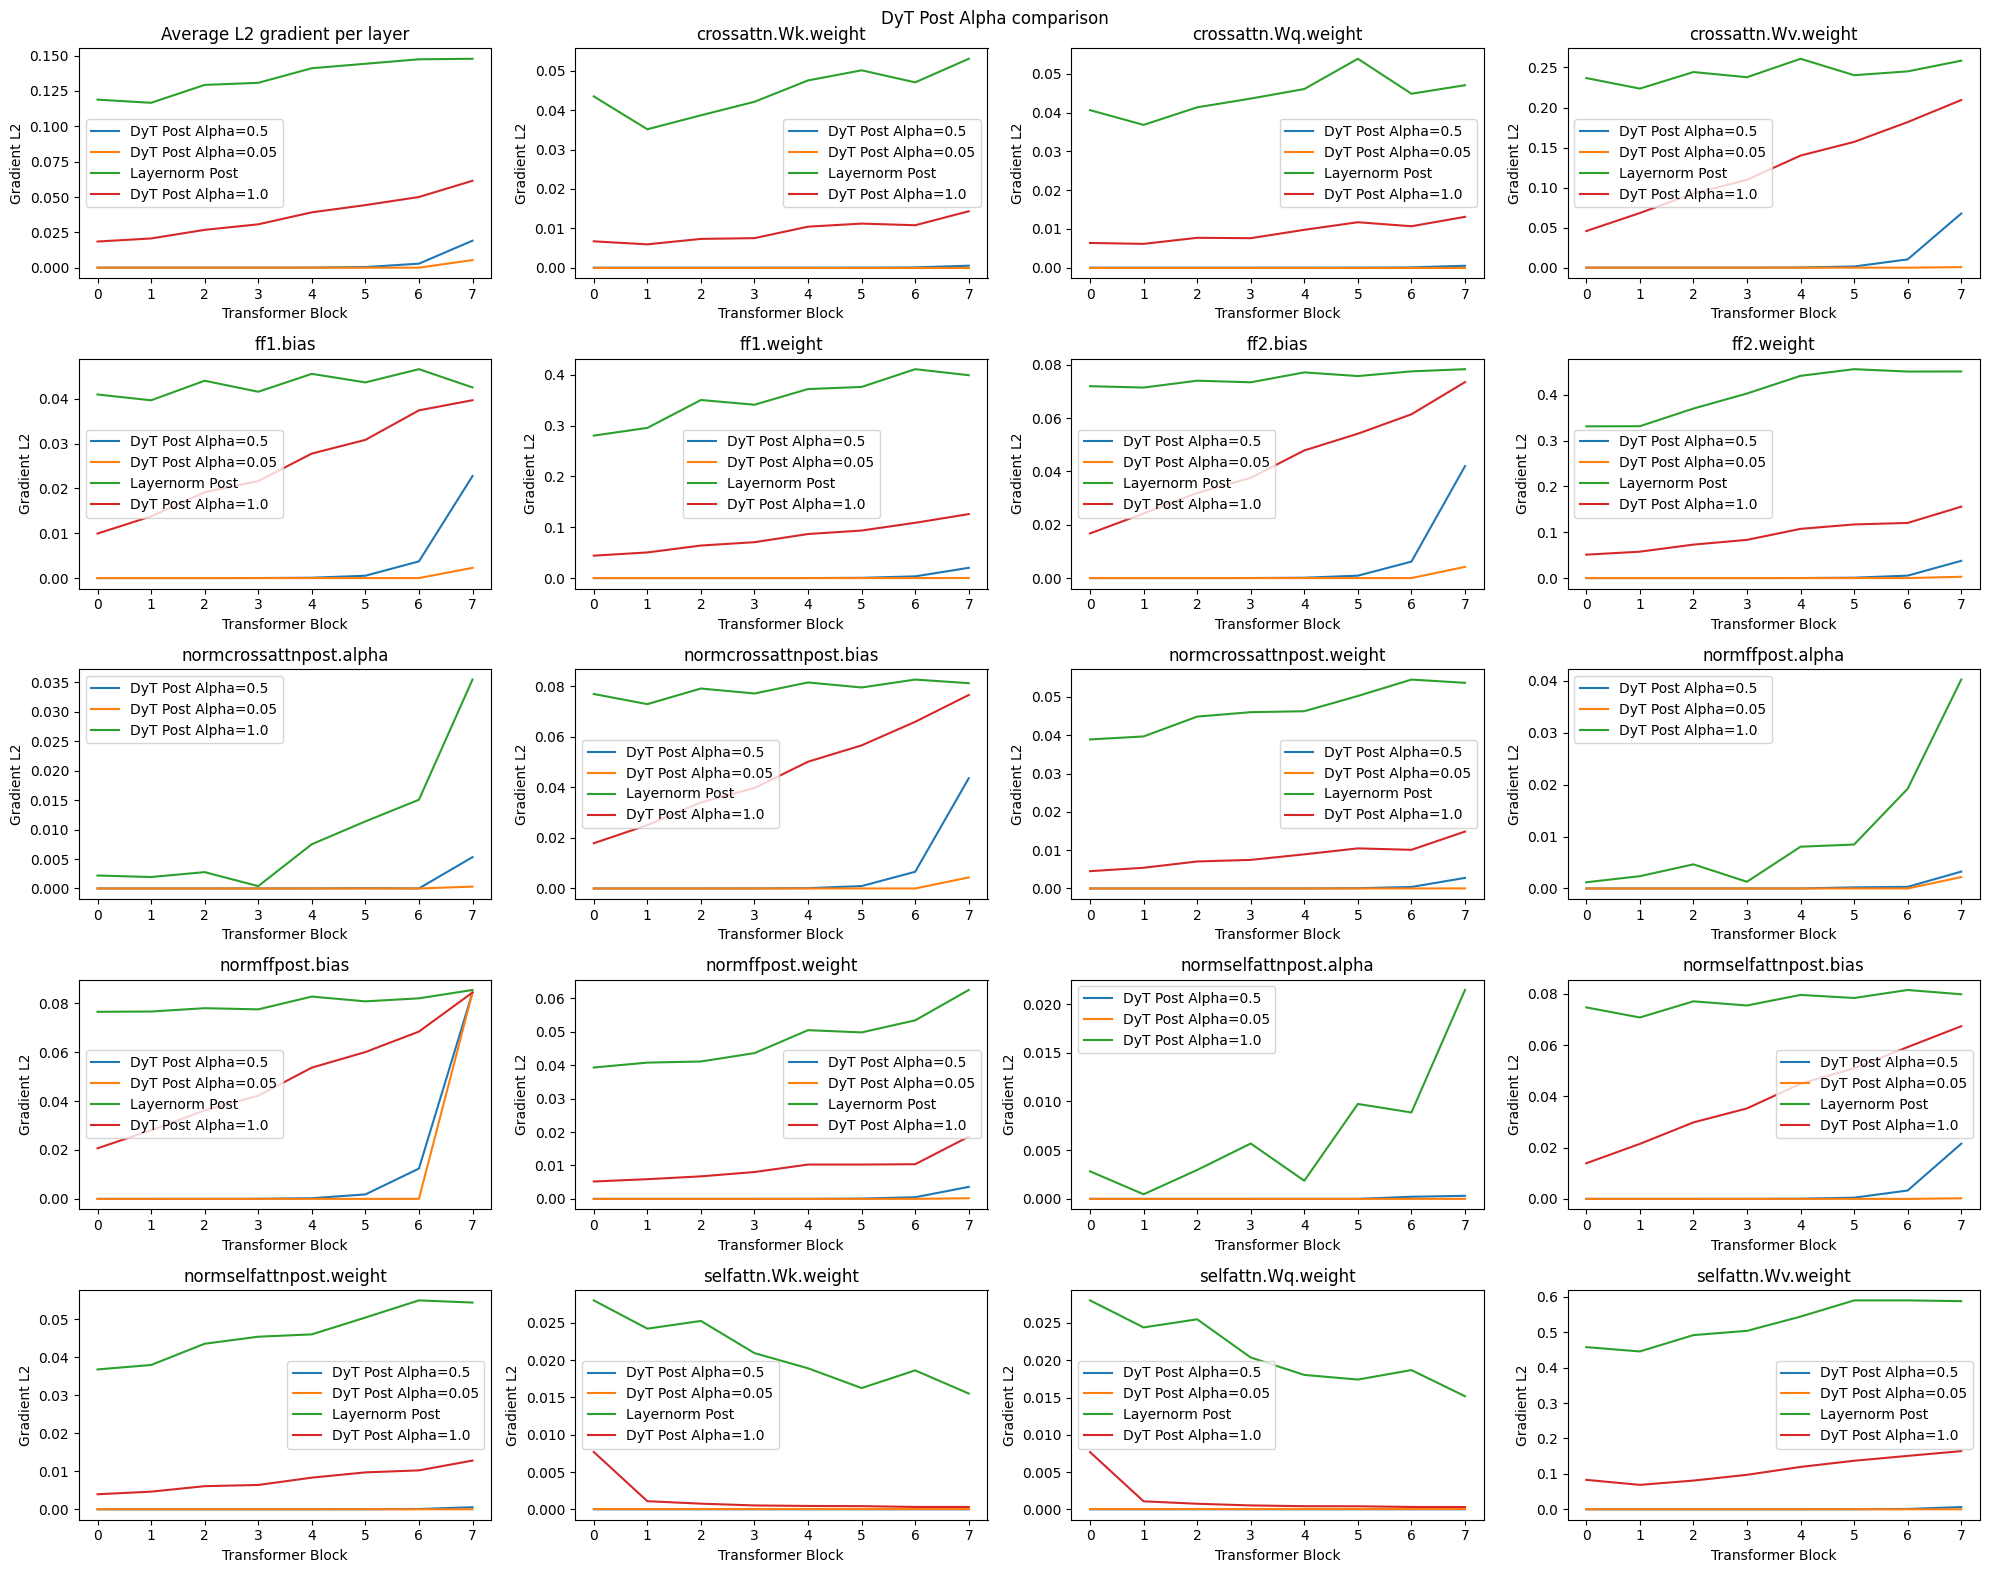

In [9]:
fig, axes = plot_multiple_grads(
    df.query("Epoch==0 & exp_group!=2 & ((Position=='Post' & DyTfn=='Tanh') | (Exp_full_name=='LayernormPost'))"),
    name="DyT Post Alpha comparison",
    name_fn=lambda x: "Layernorm Post" if np.isnan(x[1]["Alpha"]) else f"DyT Post Alpha={x[1]["Alpha"]}"
)

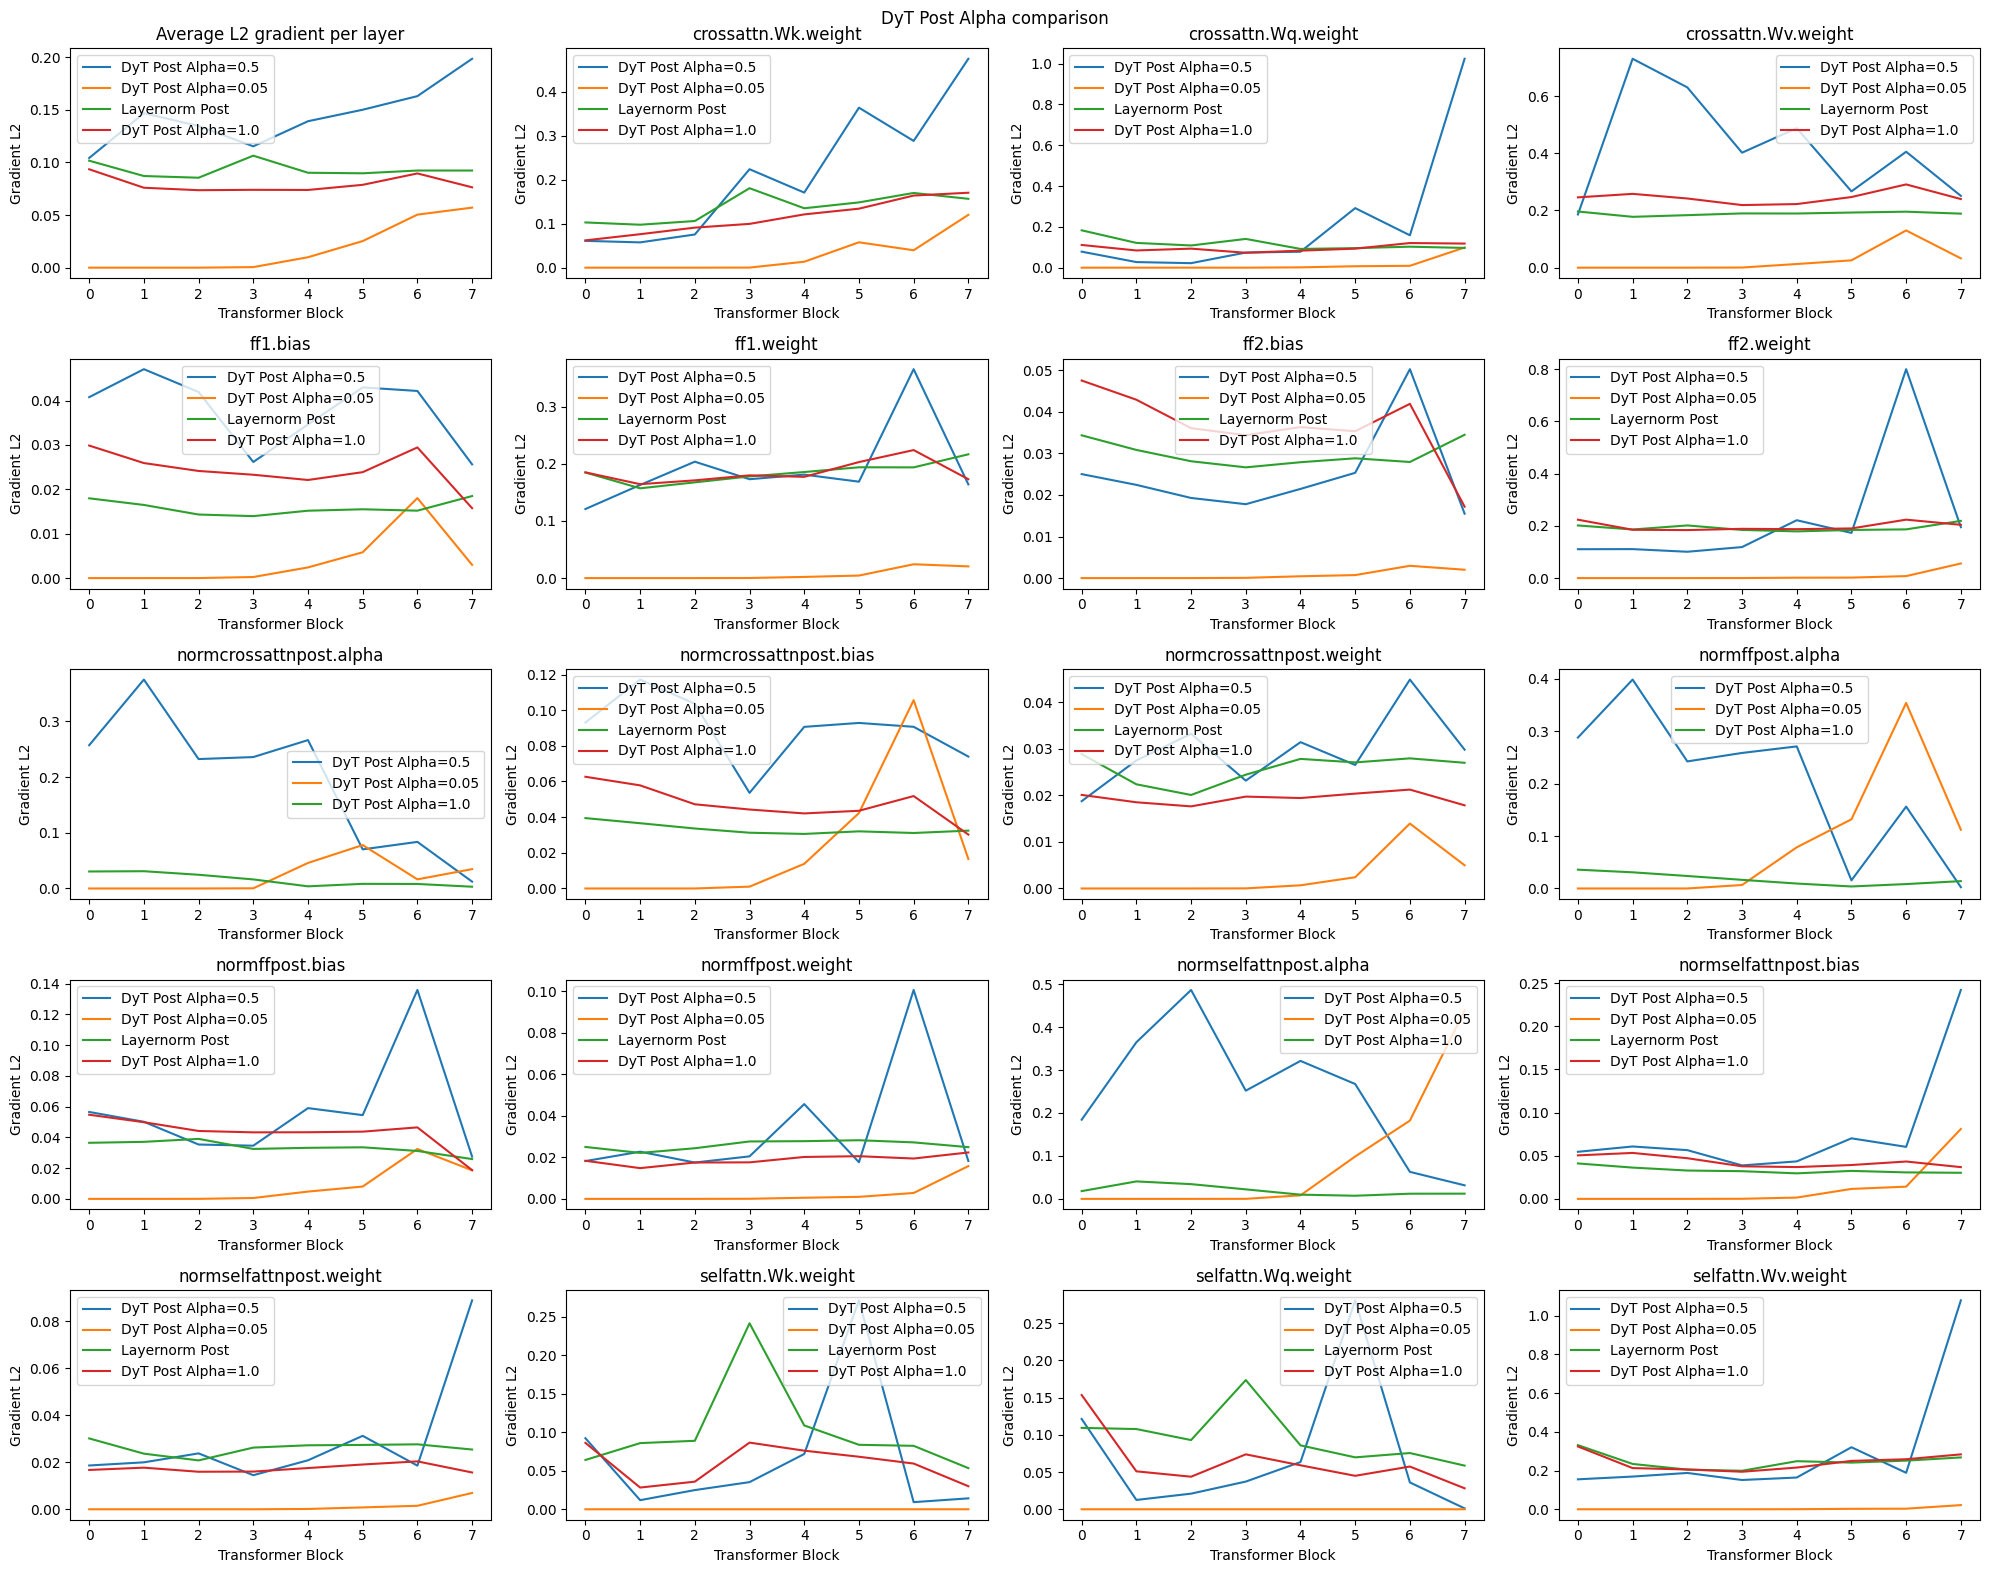

In [10]:
fig, axes = plot_multiple_grads(
    df.query("Epoch==4 & exp_group!=2 & ((Position=='Post' & DyTfn=='Tanh') | (Exp_full_name=='LayernormPost'))"),
    name="DyT Post Alpha comparison",
    name_fn=lambda x: "Layernorm Post" if np.isnan(x[1]["Alpha"]) else f"DyT Post Alpha={x[1]["Alpha"]}"
)

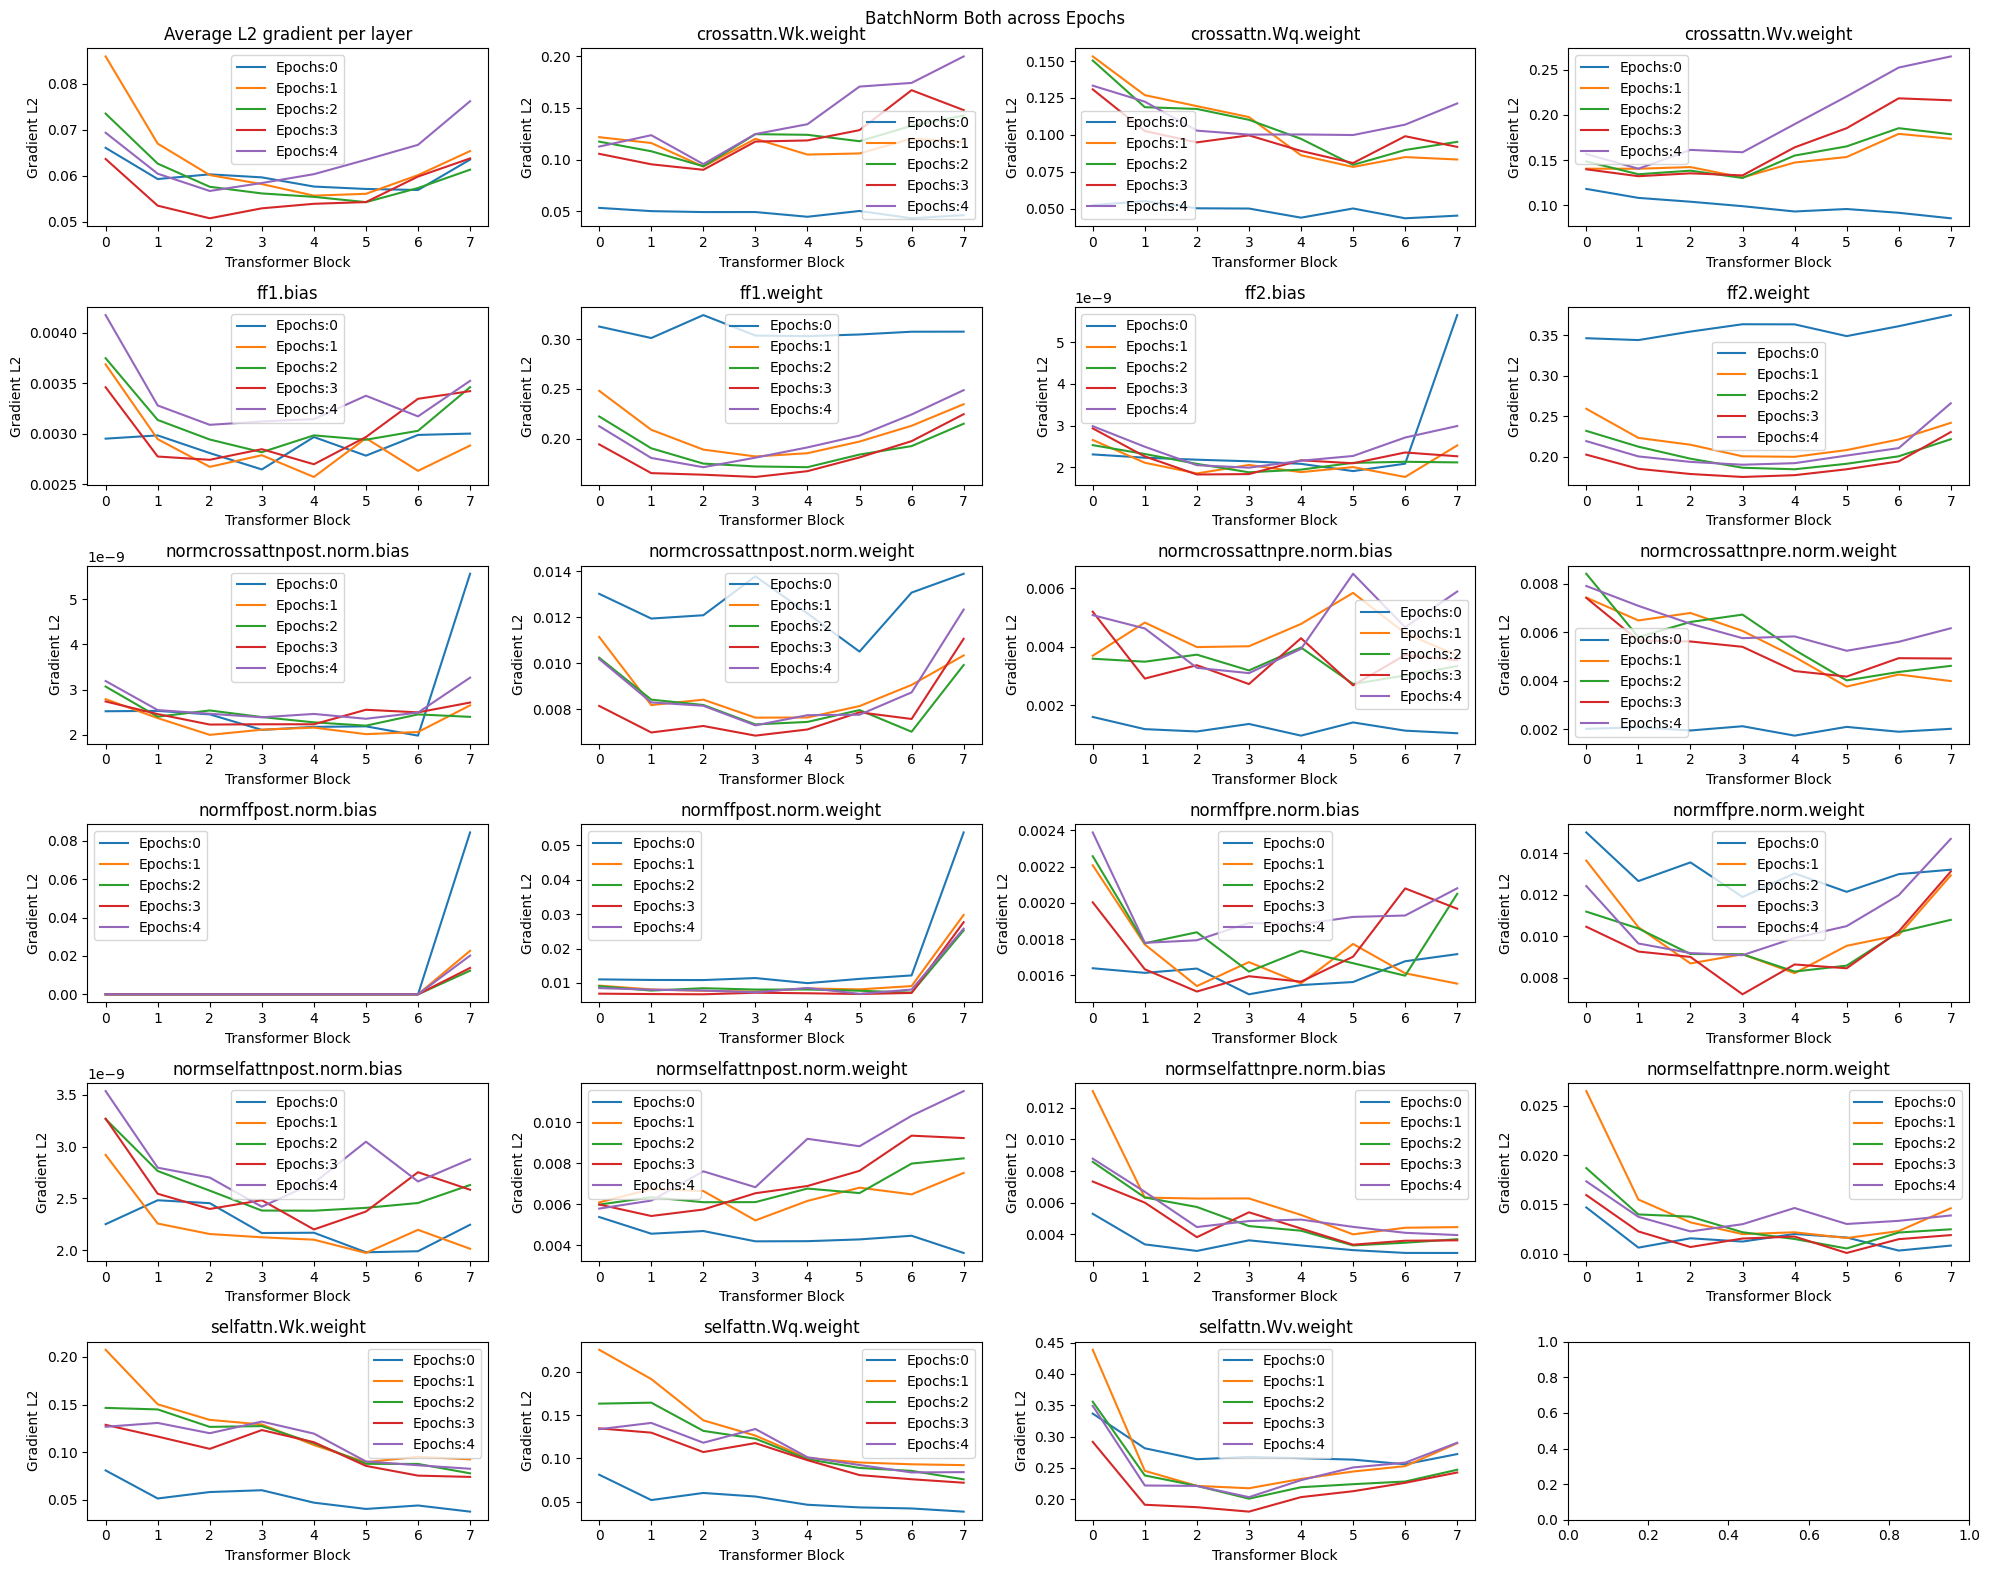

In [11]:
fig, axes = plot_multiple_grads(df.iloc[:5], name="BatchNorm Both across Epochs",name_fn=lambda x: f"Epochs:{x[1]["Epoch"]}")
plt.show()

In [12]:
df.query("Epoch==4 & exp_group!=2 & Layer=='DyT' & Position=='Post'")

,Layer,Position,Epoch,Train Loss,Eval Loss,Alpha,DyTfn,exp_group,lr,dim_hidden,Exp_full_name,Ground Truth,Prediction,Train Top-1,Train Top-5,Train Top-10,Eval Top-1,Eval Top-5,Eval Top-10,grads
44,DyT,Post,4,3.76,3.71,0.50,Tanh,1,0.0001,256.0,DyTPost,We're not really sure.,Nous Nous ne sommes pas pas.,0.38,0.57,0.64,0.37,0.57,0.64,"{'ff1.weight': [0.12084052711725235, 0.1629686..."
49,DyT,Post,4,5.36,5.72,0.05,Tanh,1,0.0001,256.0,DyTPostAlpha=0.05,We're not really sure.,Nous Nous Nous Nous Nous Nous Nous Nous Nous N...,0.13,0.36,0.45,0.07,0.25,0.35,"{'ff1.weight': [1.1524333868922695e-14, 8.2218..."
54,DyT,Post,4,3.34,3.26,0.50,Hardtanh,1,0.0001,256.0,DyTPostHardtanh,We're not really sure.,Nous n'sommes pas pas pas.,0.44,0.62,0.68,0.44,0.62,0.68,"{'ff1.weight': [0.10403416305780411, 0.0400905..."
59,DyT,Post,4,5.56,6.64,0.05,Hardtanh,1,0.0001,256.0,DyTPostHardtanhAlpha=0.05,We're not really sure.,Je Je Je Je Je Je Je Je Je Je Je Je Je Je Je J...,0.13,0.32,0.39,0.03,0.07,0.12,"{'ff1.weight': [1.3025981829902378e-15, 7.7907..."
64,DyT,Post,4,3.35,3.25,0.50,LeakyHardtanh,1,0.0001,256.0,DyTPostLeakyHardtanh,We're not really sure.,Nous ne sommes pas pas vraiment.,0.43,0.62,0.68,0.43,0.63,0.69,"{'ff1.weight': [0.06191615015268326, 0.0295933..."
69,DyT,Post,4,5.55,6.67,0.05,LeakyHardtanh,1,0.0001,256.0,DyTPostLeakyHardtanhAlpha=0.05,We're not really sure.,Je Je Je Je Je Je Je Je Je Je Je Je Je Je Je J...,0.13,0.32,0.39,0.03,0.07,0.12,"{'ff1.weight': [1.3572990413283285e-15, 8.9506..."
204,DyT,Post,4,2.41,2.33,1.00,Tanh,3,0.0001,256.0,3-DyTPostAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.56,0.75,0.79,0.57,0.75,0.80,"{'ff1.weight': [0.18498332798480988, 0.1643381..."
209,DyT,Post,4,2.25,2.18,1.00,Hardtanh,3,0.0001,256.0,3-DyTPostHardtanhAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.58,0.77,0.81,0.59,0.77,0.82,"{'ff1.weight': [0.238520547747612, 0.232768207..."
214,DyT,Post,4,2.26,2.18,1.00,LeakyHardtanh,3,0.0001,256.0,3-DyTPostLeakyHardtanhAlpha=1.0,We're not really sure.,Nous ne sommes pas vraiment sûr.,0.58,0.77,0.81,0.59,0.77,0.82,"{'ff1.weight': [0.22508977353572845, 0.1960925..."


In [13]:
df.loc[df.query("Epoch==4 & exp_group==1").groupby(["Layer"])['Eval Loss'].idxmin()]


,Layer,Position,Epoch,Train Loss,Eval Loss,Alpha,DyTfn,exp_group,lr,dim_hidden,Exp_full_name,Ground Truth,Prediction,Train Top-1,Train Top-5,Train Top-10,Eval Top-1,Eval Top-5,Eval Top-10,grads
264,BatchNorm,Pre,4,1.70,1.69,NaN,None,1,0.0001,256.0,BatchNormPre,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.65,0.84,0.88,0.65,0.84,0.88,{'normselfattnpre.norm.bias': [0.0146365677937...
74,DyT,Pre,4,1.78,1.78,0.5,Tanh,1,0.0001,256.0,DyTPre,We're not really sure.,Nous ne sommes pas vraiment vraiment.,0.64,0.83,0.87,0.64,0.83,0.87,"{'ff1.weight': [0.16243939101696014, 0.1475568..."
104,Identity,Both,4,1.74,1.71,NaN,None,1,0.0001,256.0,Identity,We're not really sure.,Nous ne sommes pas vraiment sûre.,0.64,0.83,0.87,0.65,0.84,0.87,"{'crossattn.Wq.weight': [0.15474657714366913, ..."
119,Layernorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,LayernormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,"{'normffpre.weight': [0.013368120416998863, 0...."
134,RMSNorm,Pre,4,1.71,1.70,NaN,None,1,0.0001,256.0,RMSNormPre,We're not really sure.,Nous ne sommes pas vraiment sûres.,0.65,0.84,0.88,0.65,0.84,0.88,{'normcrossattnpre.scale': [0.0110928174108266...


In [14]:
df.query("Epoch==4 & exp_group==1").groupby(["Layer", "Position"]).agg({"Eval Loss": np.min})

/tmp/ipykernel_24416/2145597980.py:1: FutureWarning: The provided callable <function min at 0x75f88c102fc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df.query("Epoch==4 & exp_group==1").groupby(["Layer", "Position"]).agg({"Eval Loss": np.min})


Eval Loss
Layer     Position           
BatchNorm Both           1.73
          Post           1.74
          Pre            1.69
DyT       Both           3.23
          Post           3.25
          Pre            1.78
Identity  Both           1.71
Layernorm Both           1.77
          Post           1.77
          Pre            1.70
RMSNorm   Both           1.77
          Post           1.78
          Pre            1.70